# T3 - Juan Luis Baldelomar Cabrera

In [1]:
import nltk 
import numpy as np

# Load Data

In [2]:
def load_data(filename, labels_filename):
    file = open(filename, 'r')
    labels_file = open(labels_filename, 'r')
    tweets = file.read()
    labels = labels_file.read()
    documents = tweets.split('\n')
    labels = labels.split('\n')
    return documents, labels

In [64]:
from nltk import TweetTokenizer
from nltk.corpus import stopwords

def process_documents(documents):
    # tokenize each document
    documents_tokenized = []
    tokenizer = TweetTokenizer()
    for doc in documents:
        documents_tokenized.append(tokenizer.tokenize(doc.lower()))
    return documents_tokenized

def remove_stop_words(documents):
    # build dictionary of stopwords
    stopwords_dict = {word:1 for word in stopwords.words('spanish')}
    non_stop_documents = []
    for doc in documents:
        ndoc = []
        for word in doc:
            if stopwords_dict.get(word) == None:
                ndoc.append(word)
        non_stop_documents.append(ndoc)
    
    return non_stop_documents

In [78]:
documents, labels = load_data('data/mex_train.txt', 'data/mex_train_labels.txt')
val_documents, val_labels = load_data('data/mex_val.txt', 'data/mex_val_labels.txt')

#remove extra lines
documents.pop(-1)
val_documents.pop(-1)
labels.pop(-1)
val_labels.pop(-1)

''

In [79]:
documents = process_documents(documents)
val_documents = process_documents(val_documents)
all_docs = documents + val_documents
y_train = list(map(int, labels))
y_val = list(map(int, val_labels))
y_all = y_train + y_val

In [80]:
documents[0]

['lo',
 'peor',
 'de',
 'todo',
 'es',
 'que',
 'no',
 'me',
 'dan',
 'por',
 'un',
 'tiempo',
 'y',
 'luego',
 'vuelven',
 'estoy',
 'hasta',
 'la',
 'verga',
 'de',
 'estl']

# BoW Builder Class

In [68]:
from nltk import TweetTokenizer
from nltk.probability import FreqDist
import numpy as np

class BoWBuilder:
    # UTILITIES
    def get_dimensions(self):
        return self.voc_index.keys()
    
    # INIT FUNCTIONS
    def __init__(self):
        # attributes
        self.voc_index = {} 
        self.train_idf = None
        self.T = 0
        
    def get_vocabulary(self, documents, T):
        # get vocabulary
        tokens = [token for doc in documents for token in doc]
        vocabulary = FreqDist(tokens)
        
        self.T = min(T, len(vocabulary.keys()))
        
        # get most common words
        limited_voc = vocabulary.most_common(T)
        self.voc_index = {}
        
        # get index of words in matrix
        for i, word_count in enumerate(limited_voc):
            self.voc_index[word_count[0]] = i
    
    
    # BUILD BOW MATRIX
    def build_bow(self, documents, T=5000, voc_index=None, mode='train', weight_scheme='binary', normalize=False):
        # get most common terms - training mode
        if mode == 'train':
            if voc_index==None:
                self.get_vocabulary(documents, T) #use most common words as vocabulary
            else:
                # use vocabulary index sent as parameter. Usefull when performing a features reduction or working with n-grams
                self.voc_index = voc_index
                self.T = len(voc_index.keys())
        
        # use train_idf, testing mode
        use_train_idf = mode != 'train'
        
        # get weights for matrix
        if weight_scheme == 'tf':
            bow = self.frequency_bow(documents)
        elif weight_scheme == 'tf-idf':
            # if documents!= None, use existing idf weights (val or test mode)
            bow = self.frequency_bow(documents, use_idf=True, use_train_idf=use_train_idf)
        else:
            bow = self.binary_bow(documents)
        
        # normalize if necessary
        if normalize:
            norm = np.linalg.norm(bow, axis=1)
            # Add 1 if norm == 0 to avoid division by 0. --  Increase 1 dimension for broadcast 
            bow = bow / (norm + (norm==0 + 0.0))[:, np.newaxis]
        
        return bow
            
    # WEIGHT SCHEMES
    def binary_bow(self, documents):
        N = len(documents)
        T = self.T
        
        bow = np.zeros((N, T))
        for i, doc in enumerate(documents):
            for word in doc:
                j = self.voc_index.get(word)
                if j != None:
                    bow[i, j] = 1 
        
        return bow
    
    def frequency_bow(self, documents, use_idf=False, use_train_idf=False):
        N = len(documents)
        T = self.T
        bow = np.zeros((N, T))
        
        # tf scheme
        for i, doc in enumerate(documents):
            for word in doc:
                j = self.voc_index.get(word)
                if j != None:
                    bow[i, j] += 1 
        
        # tf-idf scheme
        if use_idf:
            if not use_train_idf:
                # calculate idf for first time (training mode)
                self.train_idf = np.sum(bow>0, axis=0)
            
            bow = np.log(bow + 1) * np.log(N/self.train_idf)
            
        return bow        

# Feature Selection

## Chi Square

La siguiente implementación de la métrica Chi Cuadrado se encuentra basada en el libro Information Retrieval de Baeza. Sin embargo la función tiene un pequeño inconveniente y es que el denominador se puede volver 0 si para una cierta palabra $k_i$ tenemos que aparece en todos los términos, pues la ecuación es de la forma 

$$\chi^2(k_i, c_p) = \frac{N_t\Big(P(k_i,c_p)P(\bar{k}_i, \bar{c}_p)- P(k_i,\bar{c}_p)P(\bar{k}_i, c_p)\Big)^2}{P(k_i)P(\bar{k}_i)P(c_p)P(\bar{c}_p)} \quad (1)$$

Si tomamos una versión continua en función de $P(k_i)$ y $P(\bar{k}_i) = 1 - P(k_i)$ entonces podemos tomar el límite cuando $P(k_i) \rightarrow 1$. Podríamos suponer de manera razonable que si las clases están balanceadas o por lo menos no están sesgadas totalmente a una sola clase, debido a que $P(k_i)\rightarrow 1$, entonces $k_i$ aparece en casi todos los documentos y por lo tanto existe una independencia entre el evento de obtener el término $k_i$ y la clase $c_p$.  Con esta información podemos desarrollar aún más la ecuación de arriba de manera que $P(k_i, c_p) = P(k_i)P(c_p)$ (debido a que asumimos que era razonable suponer la independencia) y al aplicar el límite y tener una forma indeterminada podemos aplicar la regla de L'hospital y tras derivar tanto el numerador como el denominador tenemos que el límite es 0. 

Si analizamos esto de manera intuitiva tiene sentido. Sabemos que la $\chi^2$ cuadrado cuantifica la falta de independencia entre ambas variables. Esta métrica por definición es no negativa. Si el término $k_i$ aparece en todos los documentos (como una stop word) entonces básicamente lo podemos pensar como en que el término no revela información sobre la posible etiqueta del documento, lo cual también se sigue de que supusimos de que los eventos eran independientes.

Por lo tanto utilizaremos la métrica 

$$\chi^2(k_i, c_p) =  \begin{cases}{(1) \quad \quad \text{si} \quad P(k_i)\neq 1}\\
{0 \quad \quad \text{caso contrario}}
\end{cases}$$

Notemos que el caso $P(k_i)=0$ no es necesario considerarlo, porque en ese escenario el término no debería siquiera aparecer. Otro caso particular del denominador en que se vuelve 0 es cuando todos los documentos son de una sola etiquete. Pero como se menciono anteriormente, supondríamos que este no es el caso pues si se quiere entrenar un modelo se debe tener documentos de más de una sola clase. 

In [77]:
def chi_sqr(tf_matrix, labels):
    Nt = len(tf_matrix)
    n_i = np.sum(tf_matrix>0, axis=0)
    n_i1 = np.sum((tf_matrix * labels)>0, axis=0)
    n_i0 = np.sum((tf_matrix * (1-labels))>0, axis=0)
    n_1 = np.sum(labels, axis=0)
    n_0 = Nt - n_1
    # compute chi
    chi_1 = Nt*(Nt * n_i1 - n_1 * n_i)**2/(n_1 * n_i * (Nt - n_1) * (Nt - n_i))
    chi_0 = Nt*(Nt * n_i0 - n_0 * n_i)**2/(n_0 * n_i * (Nt - n_0) * (Nt - n_i))
    
    # get chi average
    chi_avg = n_1/Nt * chi_1 +  n_0/Nt * chi_0 
    
    return np.nan_to_num(chi_avg)

def reduce_dims(bow, voc_index, labels, n=-1, limit=-1):
    # compute chi avg
    chi_avg = chi_sqr(bow, np.array(labels)[:, np.newaxis])
    lim = np.mean(chi_avg) if limit==-1 else limit
    
    new_dict = {}
    counter = 0
    
    if n != -1:
        n_max_chi = np.flip(np.argsort(chi_avg))[:n]
        voc_index_list = list(voc_index)
        for i, index in enumerate(n_max_chi):
            word = voc_index_list[index]
            new_dict[word] = i
        chi_avg = chi_avg[n_max_chi]
    else:
        for i, word in enumerate(voc_index.keys()):
            if chi_avg[i] >= lim:
                new_dict[word] = counter
                counter += 1
        chi_avg = chi_avg[chi_avg>=lim]
        
    return new_dict, chi_avg

## Obtener vocabulario del conjunto de entrenamiento y toda la colección

Obtendremos el vocabulario a utilizar haciendo un corte con la métrica chi cuadrado para ambos conjuntos de datos.

In [81]:
bow_builder = BoWBuilder()
bow = bow_builder.build_bow(documents, T=10000, weight_scheme='tf')
voc_index, chi = reduce_dims(bow, bow_builder.voc_index, y_train, n=5000)

In [82]:
bow = bow_builder.build_bow(all_docs, T=10000, weight_scheme='tf')
all_docs_voc_index, chi = reduce_dims(bow, bow_builder.voc_index, y_all, n=5000)

# TCOR Class and PPMI

In [85]:
def ppmi(mat, alpha):
    c = np.sum(mat)**alpha 
    col_m = np.sum(mat, axis=1)[:, np.newaxis]
    row_m = np.sum(mat**alpha, axis=0)[np.newaxis, :]
    pwc= mat/c                                  #P(w,c)
    pw = col_m/c                                #P(w)
    pc = row_m/c                                #P(c)
    
    return np.maximum(np.log2(pwc/(pw * pc)), 0)  

In [97]:
from nltk.probability import FreqDist
import numpy as np
class TCOR:
    def __init__(self):
        self.voc_index = {}
        self.T = 0
        
    def get_vocabulary(self, documents, T):
        # get vocabulary
        tokens = [token for doc in documents for token in doc]
        vocabulary = FreqDist(tokens)
        print(len(vocabulary.keys()))
        
        self.T = min(T, len(vocabulary.keys()))
        
        # get most common words
        limited_voc = vocabulary.most_common(self.T)
        
        # get index of words in matrix
        for i, word_count in enumerate(limited_voc):
            self.voc_index[word_count[0]] = i
    
    def build_matrix(self, documents, window_size, alpha=0.75, mode='train', T=5000, voc_index=None, use_center=False):
        # get most common terms - training mode
        if mode == 'train':
            if voc_index==None:
                self.get_vocabulary(documents, T) #use most common words as vocabulary
            else:
                # use vocabulary index sent as parameter. Usefull when performing a features reduction or working with n-grams
                self.voc_index = voc_index
                self.T = len(voc_index.keys())
        
        term_matrix = self.frequency(documents, window_size, use_center)
        term_matrix = ppmi(term_matrix, alpha)
        return term_matrix
    
    def frequency(self, documents, window_size, use_center):
        term_matrix = np.zeros((self.T, self.T))
        
        # tf scheme
        for doc in documents:
            for c, center in enumerate(doc):
                start, end = max(0, c-window_size), min(len(doc), c + window_size + 1)
                context_words = doc[start:c] + doc[c+1:end] if not use_center else doc[start: end]
                context_index = [j for j in map(self.voc_index.get, context_words) if j != None]
                i  = self.voc_index.get(center)
                if i == None:
                    continue
                    
                for j in context_index:
                    term_matrix[i, j] += 1
        
        return term_matrix

# 1. Matriz TCOR y Visualizaciones

In [159]:
tcor = TCOR()
term_matrix = tcor.build_matrix(documents, 4, voc_index=voc_index)

/tmp/ipykernel_16278/2342482899.py:9: RuntimeWarning: divide by zero encountered in log2
  return np.maximum(np.log2(pwc/(pw * pc)), 0)


In [79]:
import numpy as np
from sklearn.manifold import TSNE
reduced_matrix = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(term_matrix)

In [81]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[0]

/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127475

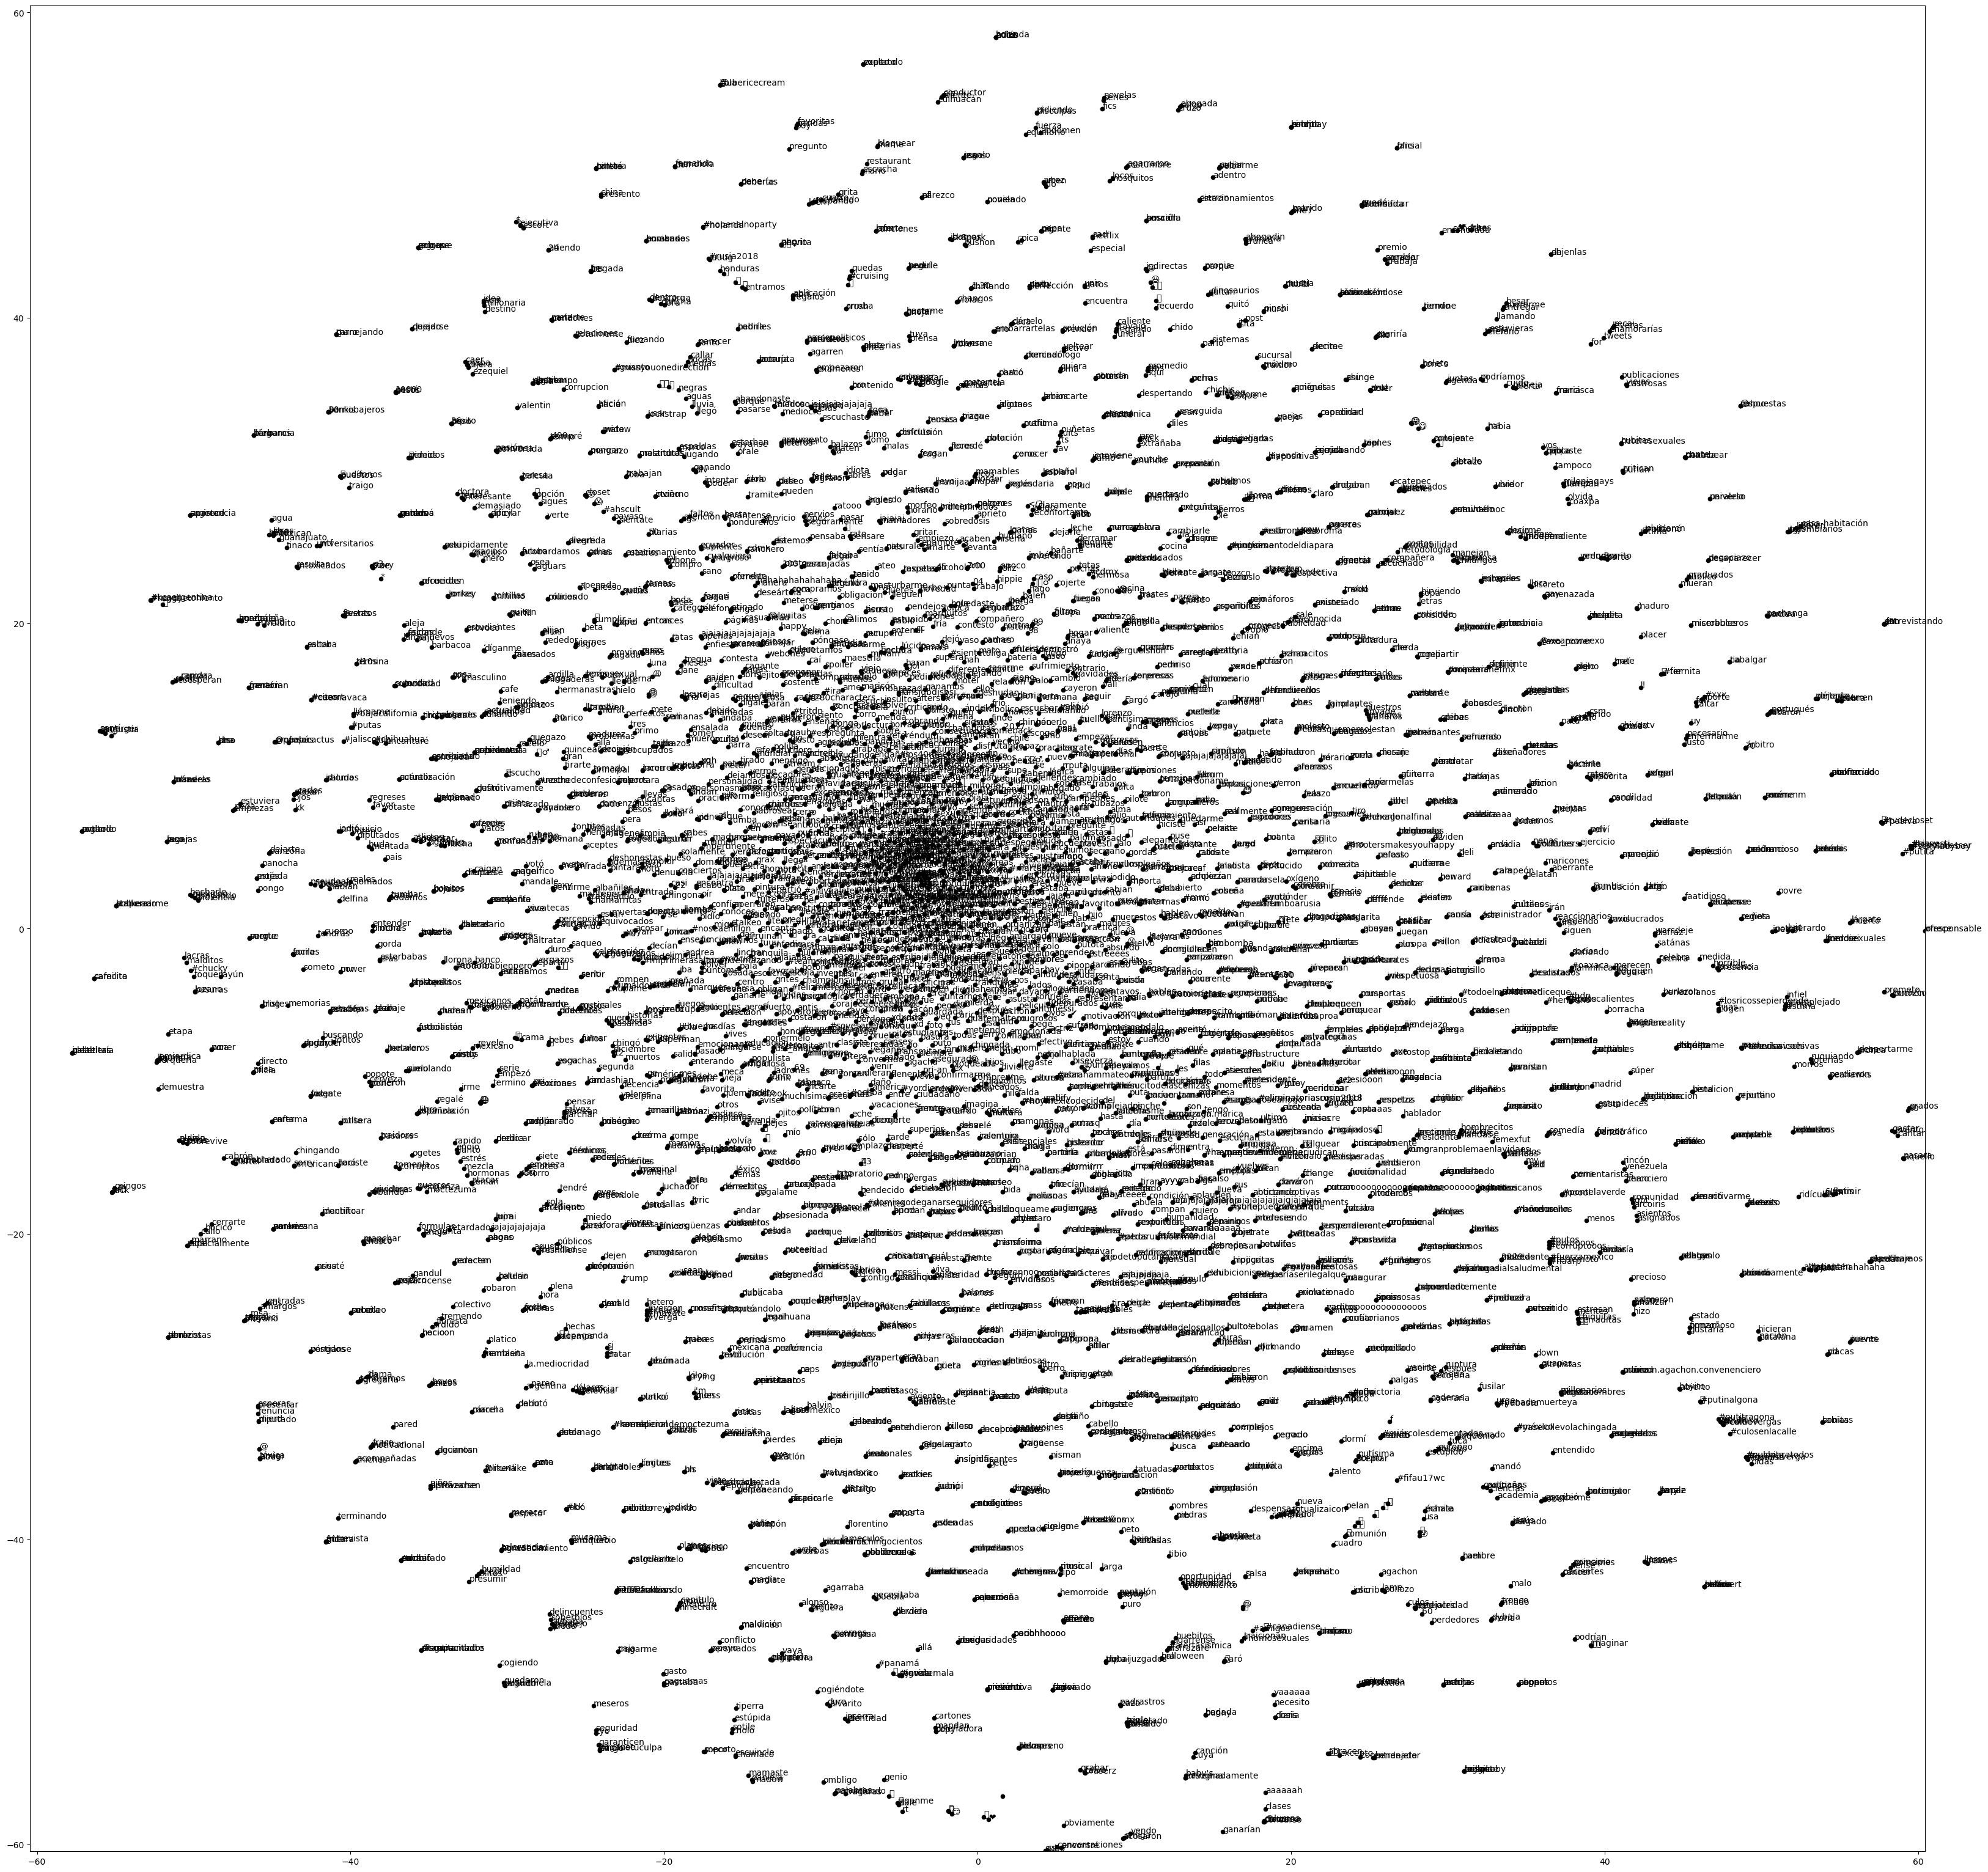

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(40, 40), dpi=100); plt.xlim((-max_x, max_x)) ; plt.ylim((-max_y, max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color='black')

for (word, idx) in tcor.voc_index.items():
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    plt.annotate(word, (x,y), color='black')

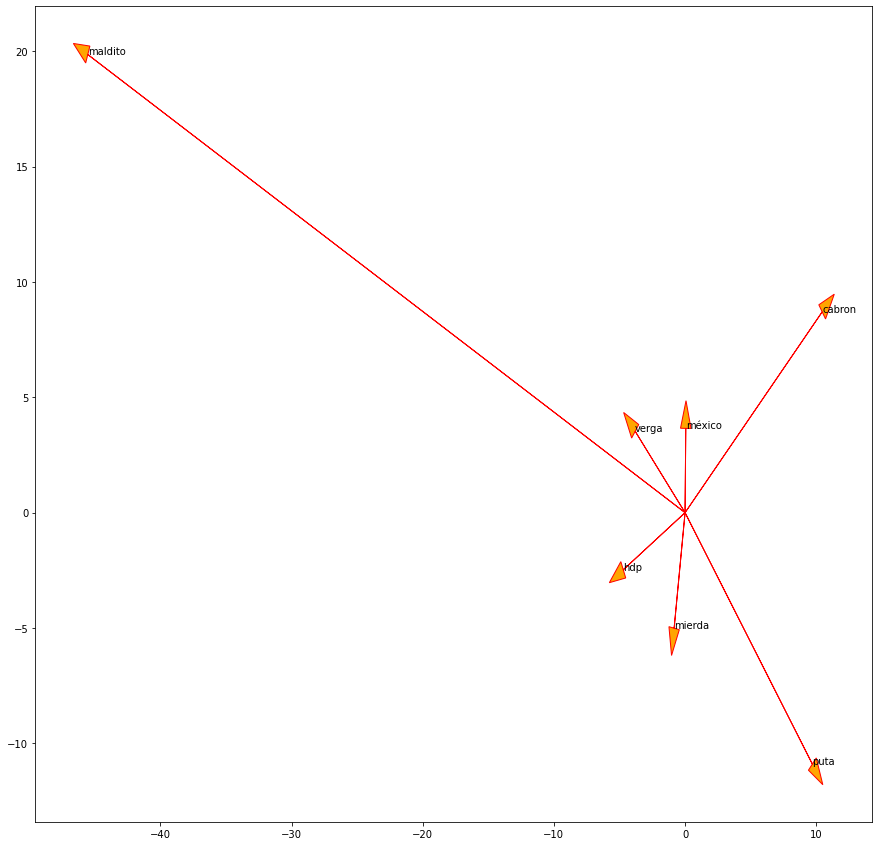

In [133]:
# get subset matrix for subset words
subset_words = ['hdp', 'mierda', 'verga', 'maldito', 'puta', 'méxico', 'cabron']
indexes = list(map(voc_index.get, subset_words))
sub_matrix = reduced_matrix[indexes]

# base figure
fig, ax = plt.subplots(figsize=(15, 15))

# add arrows
for (x, y) in sub_matrix:
    ax.arrow(0, 0, x, y, head_width=0.8, fc='orange', ec='r')
    
# add labels
for (word, point) in zip(subset_words, sub_matrix):
    ax.annotate(word, point)
    
plt.show()

In [101]:
indexes = list(map(voc_index.get, subset_words))

reduced_matrix[indexes]

array([[ -4.7104034 ,  -2.4779322 ],
       [ -0.8336685 ,  -5.0092144 ],
       [ -3.8015337 ,   3.5267015 ],
       [-45.531826  ,  19.8623    ],
       [  9.703505  , -10.900272  ],
       [  0.05383793,   3.6537743 ],
       [ 10.453084  ,   8.704796  ]], dtype=float32)

# Random Indexing Class

In [109]:
from nltk.probability import FreqDist
import numpy as np

class RandomIndex:
    def __init__(self):
        self.voc_index = {}
        self.T = 0
        
    def get_vocabulary(self, documents, T):
        # get vocabulary
        tokens = [token for doc in documents for token in doc]
        vocabulary = FreqDist(tokens)
        print(len(vocabulary.keys()))
        
        self.T = min(T, len(vocabulary.keys()))
        
        # get most common words
        limited_voc = vocabulary.most_common(self.T)
        
        # get index of words in matrix
        for i, word_count in enumerate(limited_voc):
            self.voc_index[word_count[0]] = i
    
    def build_matrix(self, documents, window_size, K, N1, T=5000, voc_index=None, mode='train'):
        # get most common terms - training mode
        if mode == 'train':
            if voc_index==None:
                self.get_vocabulary(documents, T) #use most common words as vocabulary
            else:
                # use vocabulary index sent as parameter. Usefull when performing a features reduction or working with n-grams
                self.voc_index = voc_index
                self.T = len(voc_index.keys())
        
        random_matrix = self.init_vector(K, N1)
        term_matrix = self.scan_documents(documents, window_size, random_matrix)
        return term_matrix
    
    
    def init_vector(self, K, N1):
        context_matrix = np.zeros((self.T, K))
        values = [1 for _ in range(N1)] + [-1 for _ in range(N1)]
        indexes = [np.random.choice(K, size=N1*2, replace=False) for _ in range(self.T)]
        
        for i in range(self.T):
            context_matrix[i, indexes[i]] = values
        
        return context_matrix
    
    def scan_documents(self, documents, window_size, random_v):
        term_matrix = np.zeros((self.T, random_v.shape[1]))
        
        # tf scheme
        for doc in documents:
            for c, center in enumerate(doc):
                start, end = max(0, c-window_size), min(len(doc), c + window_size + 1)
                context_words = doc[start:c] + doc[c+1:end]
                context_index = [j for j in map(self.voc_index.get, context_words) if j != None]
                i  = self.voc_index.get(center)
                if i == None:
                    continue
                    
                for j in context_index:
                    term_matrix[i] += random_v[j]
        
        return term_matrix

# 2. Random Index Matrix Y Visualizaciones

In [148]:
random_index = RandomIndex()
term_matrix = random_index.build_matrix(documents, 4, 256, 4, voc_index=voc_index)

In [149]:
import numpy as np
from sklearn.manifold import TSNE
reduced_matrix = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(term_matrix)

/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127996 (\N{EMOJI MODIFIER FITZPATRICK TYPE-3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127475

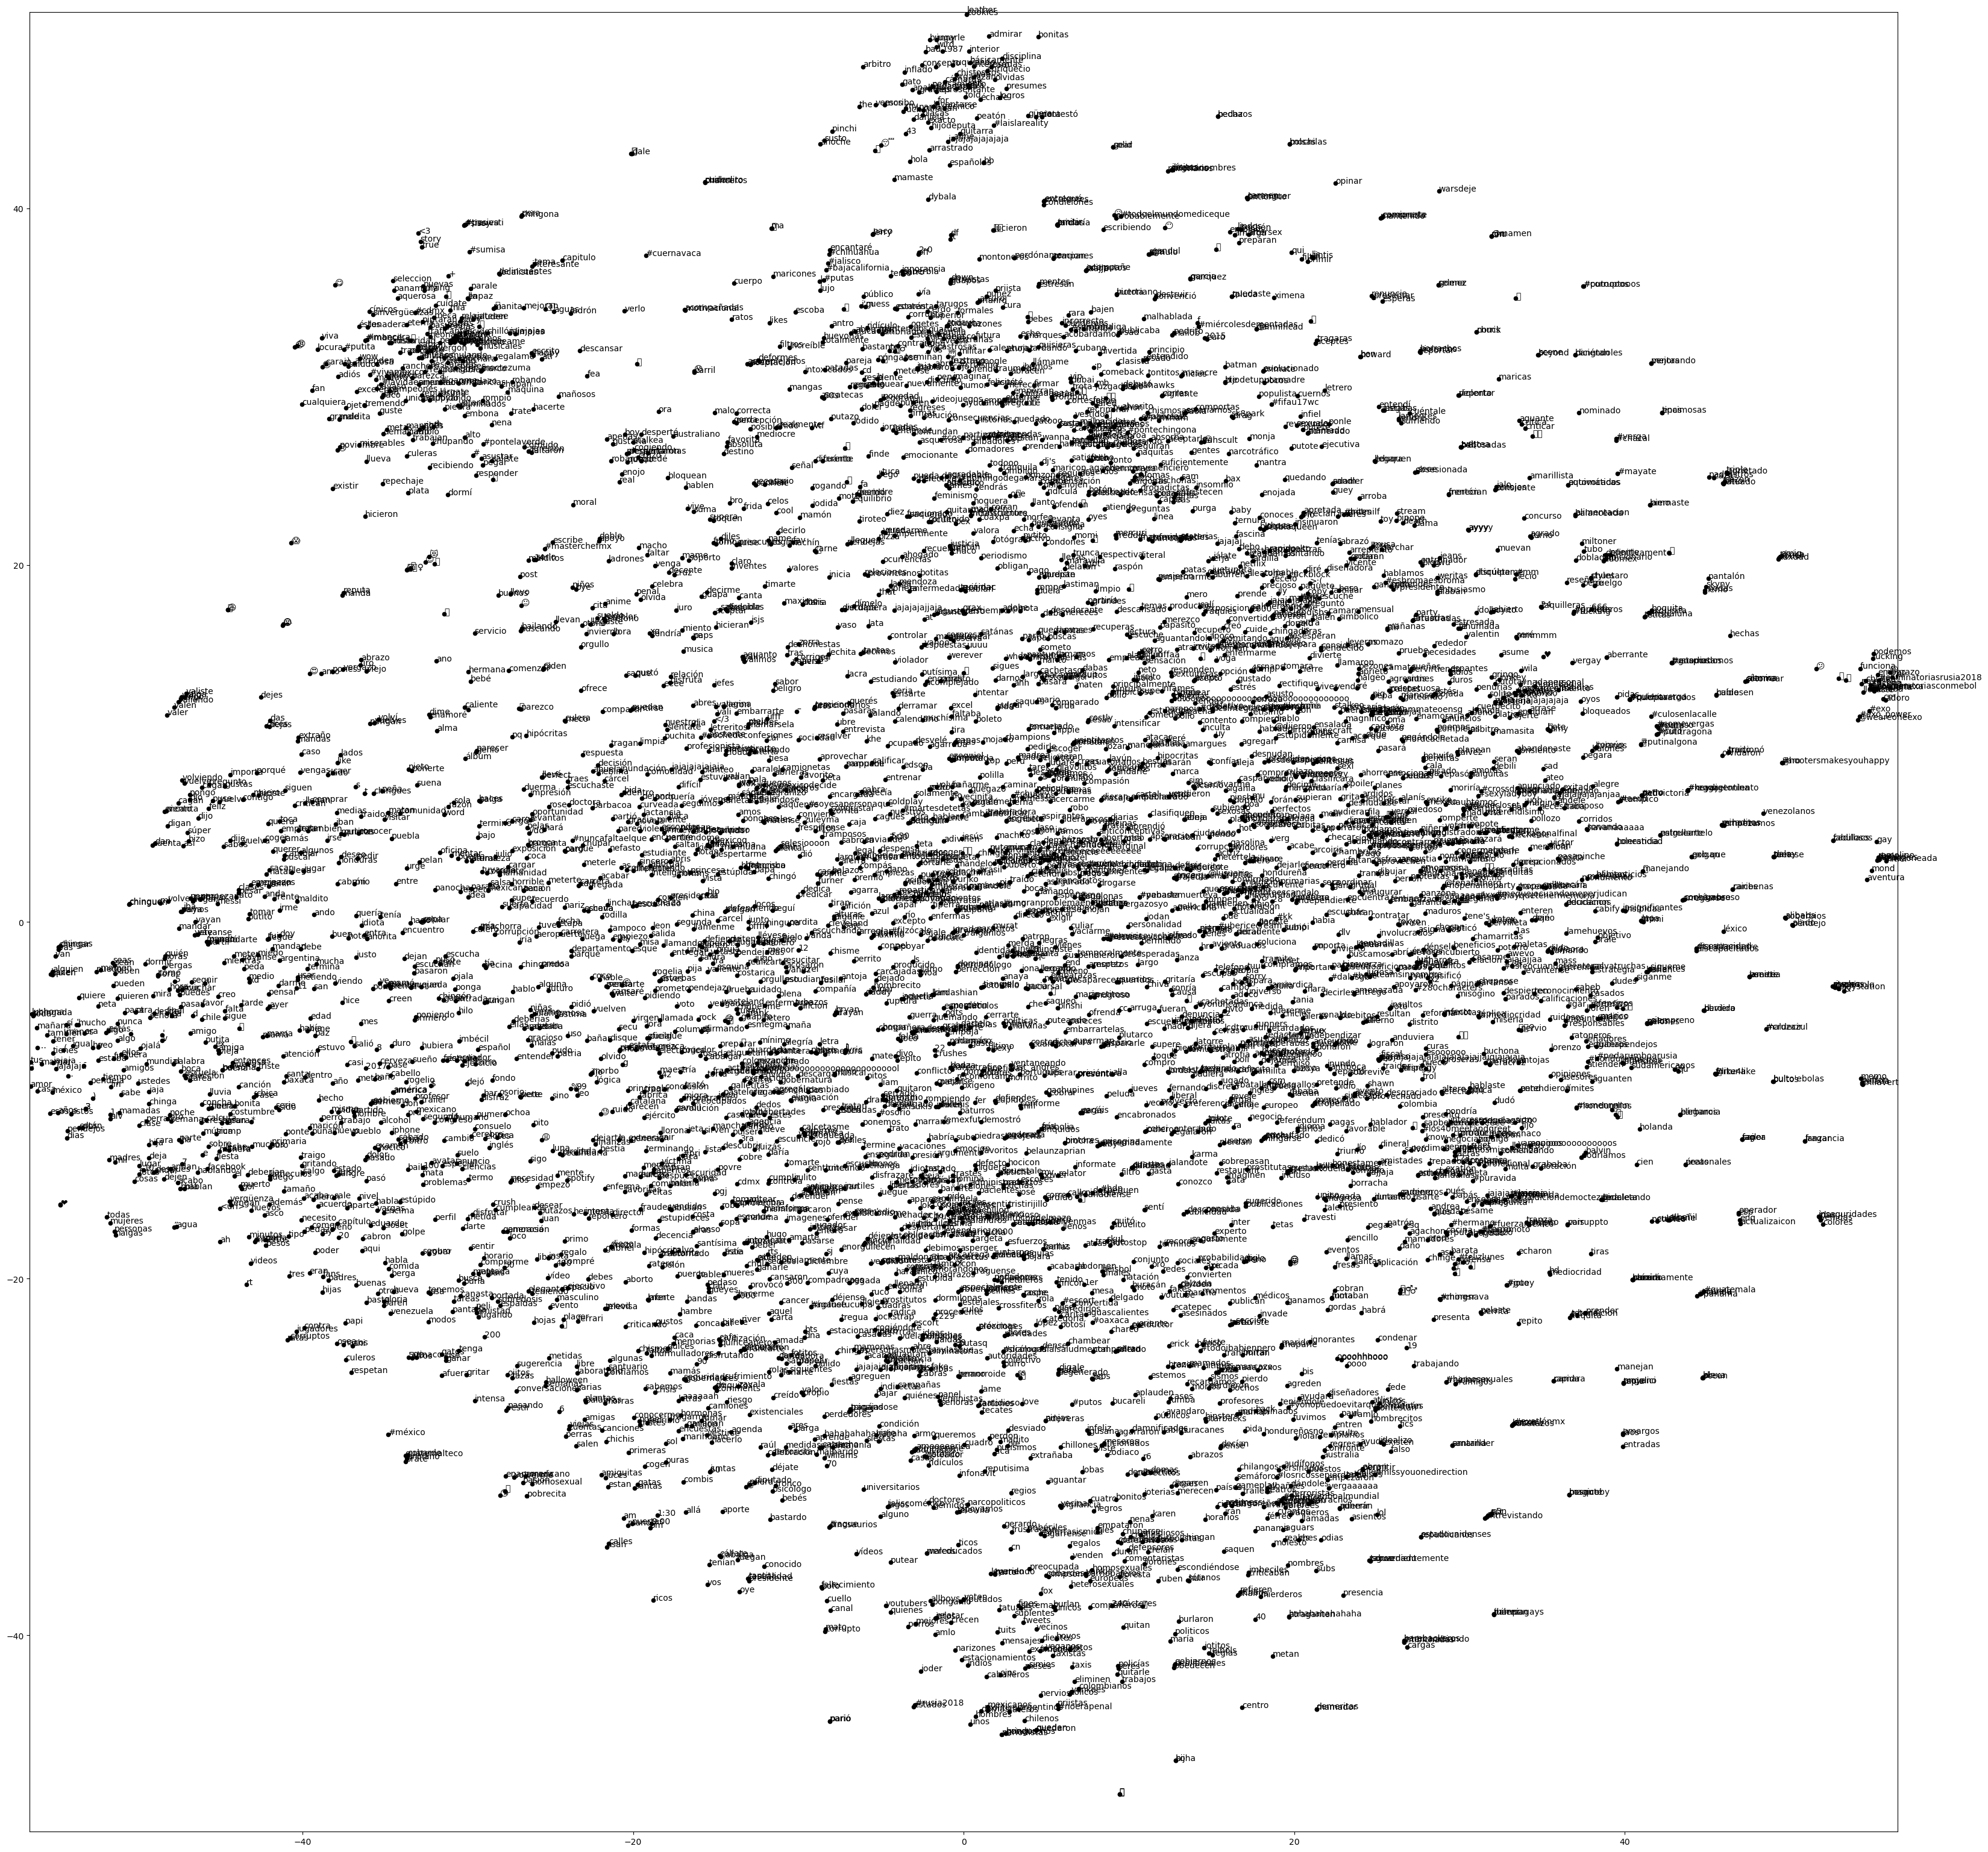

In [150]:
max_x, max_y = np.amax(reduced_matrix, axis=0)
#import matplotlib.pyplot as plt
#%matplotlib inline
plt.figure(figsize=(40, 40), dpi=100)
plt.xlim((-max_x, max_x))
plt.ylim((-max_y, max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20, color='black')

for (word, idx) in tcor.voc_index.items():
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    plt.annotate(word, (x,y), color='black')

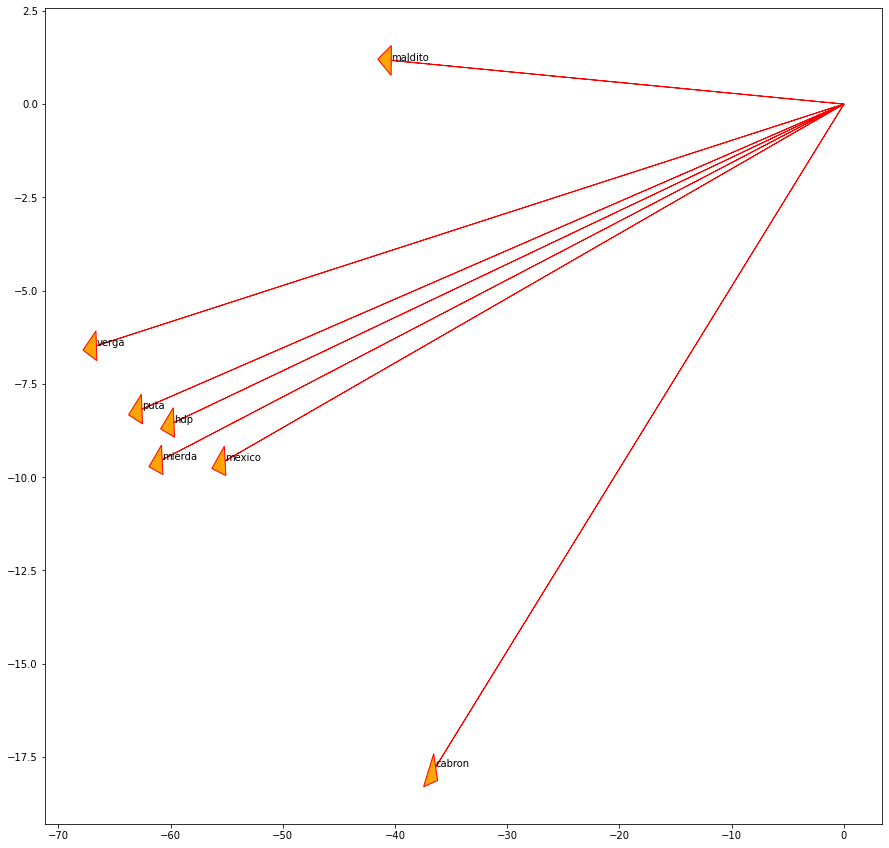

In [151]:
# get subset matrix for subset words
subset_words = ['hdp', 'mierda', 'verga', 'maldito', 'puta', 'méxico', 'cabron']
indexes = list(map(voc_index.get, subset_words))
sub_matrix = reduced_matrix[indexes]

# base figure
fig, ax = plt.subplots(figsize=(15, 15))

# add arrows
for (x, y) in sub_matrix:
    ax.arrow(0, 0, x, y, head_width=0.8, fc='orange', ec='r')
    
# add labels
for (word, point) in zip(subset_words, sub_matrix):
    ax.annotate(word, point)
    
plt.show()

# 3. Clasificación de Documentos

## SVM Model

In [62]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support

def get_model(max_iter=1000):
    parameters = {'C': [0.05, 0.12, 0.25, 0.5, 1, 2, 4]}
    svr = svm.LinearSVC(class_weight='balanced', max_iter=max_iter)
    grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring='f1_macro', cv=5) 
    return grid

def get_nl_model(max_iter=1000):
    parameters = {'C': [0.05, 0.12, 0.25, 0.5, 1, 2, 4]}
    svr = svm.SVC(kernel='poly', class_weight='balanced', max_iter=max_iter)
    grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring='f1_macro', cv=5) 
    return grid

def train_and_test(model, data, val_data):
    model.fit(data, y_train)
    pred = model.predict(val_data)
    p, r, f, _ = precision_recall_fscore_support(y_val, pred, average='macro', pos_label=None)
    a = accuracy_score(y_val, pred)
    print(" accuracy: ", a, "\n precision: ", p, "\n recall: ", r, "\n f_measure: ", f)

In [88]:
def build_document_matrix(documents, voc_index, term_matrix):
    N = len(documents)
    T = len(term_matrix[0])
    matrix = np.zeros((N, T))
    
    for (i, doc) in enumerate(documents):
        n_words = 0
        for word in doc:
            k = voc_index.get(word)
            if k!=None:
                matrix[i] += term_matrix[k]
                n_words += 1
        
        if n_words != 0:
            matrix[i]/= n_words
    
    return matrix

## TCOR Classification

In [120]:
tcor = TCOR()
term_matrix = tcor.build_matrix(documents, 4, alpha=0.75, voc_index=voc_index)
doc_matrix = build_document_matrix(documents, voc_index, term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, term_matrix)

/tmp/ipykernel_7851/2342482899.py:9: RuntimeWarning: divide by zero encountered in log2
  return np.maximum(np.log2(pwc/(pw * pc)), 0)


In [107]:
model = get_model(3000)
train_and_test(model, doc_matrix, val_doc_matrix)

/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn

 accuracy:  0.775974025974026 
 precision:  0.7569258266309205 
 recall:  0.7678479003485041 
 f_measure:  0.761038961038961


## Normalized TCOR Classification

In [121]:
norm = np.linalg.norm(term_matrix, axis=1)
normalized_term_matrix = term_matrix / (norm + (norm==0 + 0.0))[:, np.newaxis]
doc_matrix = build_document_matrix(documents, voc_index, normalized_term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, normalized_term_matrix)

In [122]:
model = get_model(3000)
train_and_test(model, doc_matrix, val_doc_matrix)

 accuracy:  0.7694805194805194 
 precision:  0.7506994503143412 
 recall:  0.7628101169731893 
 f_measure:  0.7549501899393762


## Random Indexing Classification

In [110]:
random_index = RandomIndex()
term_matrix = random_index.build_matrix(documents, 4, 1024, 8, voc_index=voc_index)
doc_matrix = build_document_matrix(documents, voc_index, term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, term_matrix)

In [111]:
model = get_model(3000)
train_and_test(model, doc_matrix, val_doc_matrix)

/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn

 accuracy:  0.42207792207792205 
 precision:  0.6677952909126289 
 recall:  0.5495899612389726 
 f_measure:  0.3719686121771006


/home/juan/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Normalized Random Indexing Classification

In [ ]:
norm = np.linalg.norm(term_matrix, axis=1)
normalized_term_matrix = term_matrix / (norm + (norm==0 + 0.0))[:, np.newaxis]
doc_matrix = build_document_matrix(documents, voc_index, normalized_term_matrix)
val_doc_matrix = build_document_matrix(val_documents, voc_index, normalized_term_matrix)

In [119]:
model = get_model(1000)
train_and_test(model, doc_matrix, val_doc_matrix)

 accuracy:  0.7597402597402597 
 precision:  0.7380960500142086 
 recall:  0.7409222134041844 
 f_measure:  0.739424703891709


## BoW TF-IDF Classification

In [123]:
# get bows, and model
bow_builder = BoWBuilder()
bow = bow_builder.build_bow(documents, T=5000, weight_scheme='tf-idf', normalize=False)
val_bow = bow_builder.build_bow(val_documents, mode='test', weight_scheme='tf-idf', normalize=False)
model = get_model(15000)
train_and_test(model, bow, val_bow)

 accuracy:  0.6948051948051948 
 precision:  0.7023890612780342 
 recall:  0.5922730984668116 
 f_measure:  0.578082191780822


## BoW TF-IDF Normalized Classification

In [112]:
# get bows, and model
bow_builder = BoWBuilder()
bow = bow_builder.build_bow(documents, T=5000, weight_scheme='tf-idf', normalize=True)
val_bow = bow_builder.build_bow(val_documents, mode='test', weight_scheme='tf-idf', normalize=True)
model = get_model(15000)
train_and_test(model, bow, val_bow)

 accuracy:  0.7256493506493507 
 precision:  0.7279454651501895 
 recall:  0.6438413673326202 
 f_measure:  0.6482200483214219


**<h2> Tabla de Resultados </h2>**

A continuación mostramos los resultados de la métrica de accuracy resumidos en una tabla para cada modelo.

**No.** | **Modelo** | **accuracy** | **precision** | **recall** | **F measure**
 -------- |----| ---- | ---- | ---- | ----
1 |`TCOR` | 0.8133  | 0.7958 | 0.8071 | 0.8003
2 | `Normalized TCOR` | 0.8182 | 0.8008 | 0.8088 | 0.8043
3 | `Random Indexing` | 0.6948 | 0.7024 | 0.5923 | 0.5781 
4 | `Normalized Random Indexing` | 0.7987 | 0.7809 | 0.7937 | 0.7857
5 | `TF-IDF` | 0.7955 | 0.7775 | 0.7901 | 0.7822
5 | `Normalized TF-IDF` | 0.7256 | 0.7279 | 0.6438 | 0.6482

# Distancia Coseno

In [12]:
def cos_distance(data):
    N = len(data)
    distances = np.zeros((N, N))
    magnitudes = np.linalg.norm(data, axis=1)
    
    for i in range(N):
        for j in range(i+1):
            distances[i, j] = np.dot(data[i], data[j])/(magnitudes[i] * magnitudes[j])
            if i != j:
                distances[j, i] = distances[i, j]
    
    return distances

In [13]:
def get_most_similar(dist_matrix, n):
    N = len(dist_matrix)
    indexes = [(i,j) for i in range(N) for j in range(i+1) if i!=j]
    x_indexes = tuple([ind[0] for ind in indexes])
    y_indexes = tuple([ind[1] for ind in indexes])
    row_max = dist_matrix[x_indexes, y_indexes]
    max_elements = np.flip(np.argsort(row_max))[:n]
    return [indexes[max_index] for max_index in max_elements]

# 4. 10 Términos más Similares

In [160]:
tcor_distances = cos_distance(term_matrix)
dist_matrix = np.nan_to_num(tcor_distances)

/tmp/ipykernel_16278/1082726312.py:8: RuntimeWarning: invalid value encountered in double_scalars
  distances[i, j] = np.dot(data[i], data[j])/(magnitudes[i] * magnitudes[j])


In [216]:
indexes = get_most_similar(dist_matrix, 10)
for (i, j) in indexes:
    l_voc = list(voc_index)
    print("{0:40}, {1:30}, score: {2}".format(l_voc[i], l_voc[j], dist_matrix[i, j]))

jajajajajajajajajajajajajajjajqjajajaja , teo                           , score: 1.0000000000000002
gomez                                   , selena                        , score: 1.0000000000000002
aberrante                               , . .                           , score: 1.0000000000000002
desactivarme                            , ocurrió                       , score: 1.0000000000000002
subió                                   , juanpi                        , score: 1.0000000000000002
ponganlo                                , allboys                       , score: 1.0000000000000002
hijodetuputamadre                       , zte                           , score: 1.0000000000000002
madriada                                , programacion                  , score: 1.0000000000000002
piruja                                  , llévese                       , score: 1.0000000000000002
#heydj                                  , #reggaetonlento               , score: 1.0000000000000002


# 5. 10 Documentos más Similares

In [16]:
bow_builder = BoWBuilder()
bow = bow_builder.build_bow(documents, voc_index=voc_index)
distances = cos_distance(bow)
distances = np.nan_to_num(distances)
indexes = get_most_similar(distances, 10)

In [24]:
docs = documents
for (i, j) in indexes:
    print('Document: ', i)
    for word in docs[i]:
        print(word, end=' ')
    print('\nDocument: ', j)
    for word in docs[j]:
        print(word, end=' ')
        
    print('\n\033[1mscore:\033[0m ', distances[i, j], '\n')

Document:  4152
una flaquita tetona recibe su dotación mientras chupa otra verga ! ¡ mira su cara de placer ! rt para más vídeos 
Document:  2720
una flaquita tetona recibe su dotación mientras chupa otra verga ! ¡ mira su cara de placer ! rt para más vídeos 
score:  1.0000000000000002 

Document:  5227
quiero un pasivo que se ensarte mi verga así 🔥 🔥 como @usuario cabalga la verga de @usuario 
Document:  3693
quiero un pasivo que se ensarte mi verga así 🔥 🔥 como @usuario cabalga la verga de @veguerovzla 
score:  1.0 

Document:  3373
madre preocupada por los tatuajes de su hijo toma medidas desesperadas 
Document:  1314
#deforma #deforma madre preocupada por los tatuajes de su hijo toma medidas desesperadas 
score:  0.9999999999999998 

Document:  4020
ama hasta que te duela . si te duele es buena señal ” . ( madre teresa de calcuta ) . #citas 
Document:  3587
“ ama hasta que te duela . si te duele es buena señal ” . ( madre teresa de calcuta ) . #citas 
score:  0.9682458365518541 

D

# 6. Nube de Palabras

In [58]:
bow_builder = BoWBuilder()
bow = bow_builder.build_bow(documents, T=10000, weight_scheme='tf')
top_50, chi = reduce_dims(bow, bow_builder.voc_index, n=50)
frequencies = {}
for (word, weight) in zip(top_50.keys(), chi):
    frequencies[word] = weight * 10

In [59]:
frequencies

{'hdp': 3366.940109756046,
 'loca': 2952.386194185803,
 '@usuario': 2721.481850282203,
 'putos': 1747.2171409255388,
 'me': 1198.8163428515488,
 'tu': 1047.1732142981111,
 'hijos': 885.6707172056656,
 'pendejo': 874.4242165153156,
 'puto': 834.1375551494644,
 'son': 830.2306642812068,
 'puta': 781.8483780061447,
 'mamar': 748.5513166338919,
 'mierda': 726.3874214801473,
 'pendejos': 713.1182034986493,
 'hijo': 699.4888700578051,
 'chinguen': 669.3811319012319,
 'estoy': 667.5077613058877,
 'pinche': 622.4200488497057,
 'verga': 598.3826066163522,
 'mi': 588.5885712638901,
 'los': 577.5834523707572,
 'chingas': 484.7039698704949,
 'chinga': 477.7240668085909,
 'pinches': 476.05294773912334,
 'su': 459.8130735775021,
 'esos': 449.7511104856727,
 'mundial': 438.48041036299634,
 'chingar': 431.1036189191458,
 'a': 419.3814941882229,
 'mil': 387.830231189253,
 'hondureños': 379.14477309791096,
 'lameculos': 379.1393139770788,
 'bola': 361.0196943373343,
 '…': 357.839612179058,
 'vida': 353.

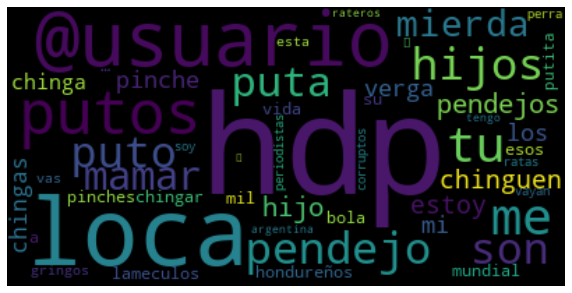

In [61]:
import os
from os import path
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate_from_frequencies(frequencies)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Pruebas

In [37]:
tcor = TCOR()

In [46]:
matrix = tcor.build_matrix(documents, 1, T=100)

24


In [36]:
documents = []
documents.append('hola como estas, hoy voy a comer pizza')
documents.append('hoy voy a comer pizza con mis amigos')
documents.append('hola, quiero la receta del pie de manzana')
documents.append('te gusta el pie de manzana')
documents.append('juan fue a comer pizza')

documents = process_documents(documents)